# Generate visible slope distribution from shadow lookup table

Using a ray-casting shadow lookup table, return a table of probabilities that a given surface facet (az, slope) is in shadow. The probabilities are interpolated from the lookup table which includes ray-casting runs from a variety of synthetic Gaussian surfaces with varying RMS slopes and local solar incidence angles. 

The inputs to the function are:

- `rms_slope`: Root-mean-square slope of a Gaussian slope distribution of surface facets
- `sun_theta`: To-sun incidence angle w.r.t. the surface
- `sun_az`: To-sun azimuth angle w.r.t. the surface
- `sc_theta`: To-spacecraft exitance angle w.r.t. the surface
- `sc_az`: To-spacecraft azimuth angle w.r.t. the surface
- (optional) `shadow_lookup_path`: Path to custom 4D shadow lookup file

The default lookup table `shade_lookup_4D.npy` predicts shadowing across:

- RMS slopes from 0 to 50 degrees (in 5 degree increments)
- cos(solar incidence angle) from 0 to 1 (in 0.1 increments)

The table returns a 2D grid of probabilities of slope shadowing corresponding to the following range of facet slope azimuth and angle combinations:

- Slope azimuths measured from North from 0 to 360 degrees (in 10 degree increments)
- Slope angles measured from a level surface from 0 to 90 degrees (in 2 degree increments)

The table interpolates between the supplied RMS slope (`rms_slope`) and solar incidence angle (`sun_theta`) and returns the 2D grid of shadow probabilities as a function of azimuth and slope angle.

Since shadow lookup was generated with solar azimuth = 270 degrees, we rotate the table such that the shadowing of the returned facets are specified with respect to the supplied solar azimuth (`sun_az`).

Since the observed shadowing distribution will vary based on the observation direction, the shadow facet table is also projected onto the plane perpendicular to the vector of the viewing direction supplied (`sc_theta`, `sc_az`). For example, at 0 phase angle (spacecraft and sun vectors are the same), all shadows from the point of view of the spacecraft are hidden.

In [9]:
import sys
sys.path.append('/home/ctaiudovicic/projects/roughness')
import numpy as np
import matplotlib.pyplot as plt
from roughness import roughness as r
plt.style.use('dark_background')

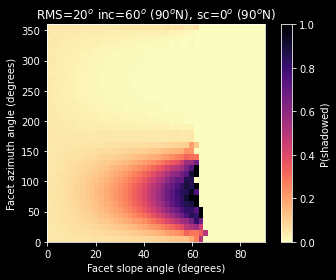

In [11]:
rms_slope = 20
sun_theta = 60
sun_az = 90
sc_theta = 0
sc_az = 90
sl = r.load_shadow_lookup()

shadow_frac = r.get_shadow_table(rms_slope, sun_theta, sun_az, sl)

# shadow_frac = r.main(rms_slope, sun_theta, sun_az, sc_theta, sc_az)
_, _, facet_azs, facet_slopes = r.get_lookup_coords(0, 0, *shadow_frac.shape)

plt.imshow(shadow_frac, extent=(0, 90, 0, 360), aspect=90/360, cmap='magma_r', vmin=0)
plt.title(f'RMS={rms_slope}$^o$ inc={sun_theta}$^o$ ({sun_az}$^o$N), sc={sc_theta}$^o$ ({sc_az}$^o$N)')
plt.xlabel('Facet slope angle (degrees)')
plt.ylabel('Facet azimuth angle (degrees)')
plt.colorbar(label='P(shadowed)')

In [3]:
def viewing_correction(sc_theta, sc_az, theta_grid, az_grid):
    """
    Return the fraction of surface facets (theta_grid, az_grid) visible from the viewing direction (sc_theta, sc_az). Visible faction is the projection of the surface facets onto a plane orthogonal to the viewing vector.

    Parameters
    ----------
    sc_theta (num): To-spacecraft emission angle [deg].
    sc_az (num): To-spacecraft azimuth angle from North [deg].
    theta_grid (2D array): Corordinate grid specifying each facet slope angle
    az_grid (2D array): Corordinate grid specifying each facet azimuth angle

    Returns
    -------
    correction (2D array): Fraction of each facet visible from the spacecraft.
    """
    # Get cartesian grid of facet vectors
    cartesian_surf = sph2cart(np.radians(theta_surf), np.radians(azimuth_surf))
    
    # Spacecraft unit vector
    theta, azimuth = (np.radians(sc_theta), np.radians(sc_az))
    cartesian_sc = sph2cart(theta, azimuth)

    # Cartesian dot product gives cos(angle) between vectors
    cos_surf_sc = np.dot(cartesian_surf, cartesian_sc)

    # Negative cos means facet oriented away from spacecraft (not visible)
    cos_surf_sc[cos_surf_sc < 0] = 0

    # Normalize
    visible_facets = cos_surf_sc / cos(np.radians(theta_surf))
    return 



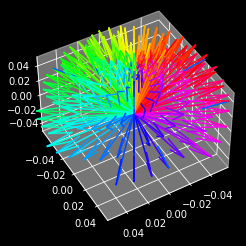

In [12]:
# Sanity check on facet vectors (slope in 0-90, az in 0-360)
theta_surf, azimuth_surf = r.get_facet_grids()
cartesian_surf = r.sph2cart(np.radians(theta_surf), np.radians(azimuth_surf))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, 60)

X, Y, Z = cartesian_surf.reshape((37*46, 3)).T + 1e-8
O = np.zeros(len(X))  # origin

# Color by az angle
c = np.arctan2(Y, X)
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# Colormap
c = plt.cm.hsv(c)

s = slice(None, None, 11)
q = ax.quiver(O[s], O[s], O[s], X[s], Y[s], Z[s], colors=c[s], length=0.08, normalize=True)


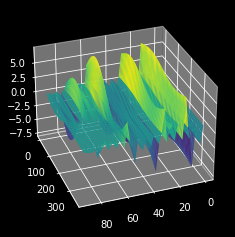

In [13]:
# Transcibed the "correction" steps from TI_Scripts. This
# part should do the view angle correction but... looks weird
theta, az = (np.radians(30), np.radians(sc_az))

cartesian_sc = r.sph2cart(theta, az)
cos_surf_sc = np.dot(cartesian_surf, cartesian_sc)

angle = np.arccos(cos_surf_sc)
angle[angle > np.pi/2] = np.pi/2
corr = (1/np.cos(theta_surf))*np.cos(angle)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30, 70)

ax.plot_surface(theta_surf, azimuth_surf, corr, cmap='viridis')

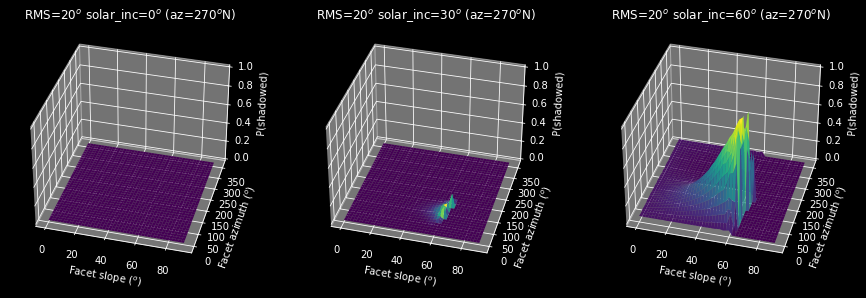

In [14]:
# Get shadow table from lookup
rms_slope = 20
solar_az = 270

fig = plt.figure(figsize=(15, 8))
sun_thetas = (0, 30, 60)
for i, solar_inc in enumerate(sun_thetas):
    shadow_table = r.get_shadow_table(rms_slope, solar_inc, solar_az, sl)
    ax = fig.add_subplot(1, len(sun_thetas), i+1, projection='3d')
    ax.view_init(35, -75)
    ax.plot_surface(theta_surf, azimuth_surf, shadow_table, cmap='viridis')
    ax.set_title(f'RMS={rms_slope}$^o$ solar_inc={solar_inc}$^o$ (az={solar_az}$^o$N)')
    ax.set_xlabel('Facet slope ($^o$)')
    ax.set_ylabel('Facet azimuth ($^o$)')
    ax.set_zlabel('P(shadowed)')
    ax.set_zlim(0, 1)

# plt.savefig('./shadow_tables.png', dpi=300)

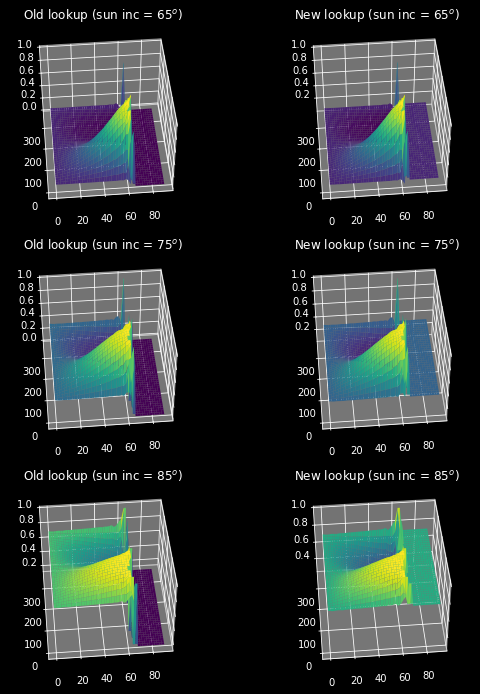

In [38]:
# This script mitigates a bug with the old shadow_lookup produced by J.B.
# Old table had null values of ray-casting set to 0 (e.g. fully illuminated).
# This causes very extreme slopes oriented away from sun to appear un-shadowed.
# Here, we set reset all 0 values in the table to the value at 0 degree facets
# New lookup is still bad... but less bad. 
# Replace this script and the old lookups with new ray-cast lookup when ready.
import numpy as np
import matplotlib.pyplot as plt
import roughness.roughness as r

# Load old shadow_lookup
sl = r.load_shadow_lookup()  # 'shade_lookup_4D_old.npy'
new_sl = sl.copy()
for i, rms in enumerate(sl):
    for j, shadow_table in enumerate(rms):
        # Set shadow minimum to shadow fraction at surface theta = 0 
        new_sl[i, j][new_sl[i, j] <= 0] = np.mean(new_sl[i, j, :, 0])

# Save new shadow_lookup
np.save('shade_lookup_4D_new.npy', new_sl)

# Plot comparison
fig = plt.figure(figsize=(9, 12))
theta_surf, azimuth_surf = r.get_facet_grids()
rms_slope = 20
solar_az = 270

# Loop thru solar incidences and plot old vs new
for i, sun_theta in enumerate((65, 75, 85)):
    shadow_table = r.get_shadow_table(rms_slope, sun_theta, solar_az, sl)
    new_shadow_table = r.get_shadow_table(rms_slope, sun_theta, solar_az, new_sl)

    # Old shadow lookup
    ax = fig.add_subplot(3, 2, 2*i+1, projection='3d')
    ax.view_init(45, -95)
    ax.plot_surface(theta_surf, azimuth_surf, shadow_table, cmap='viridis')
    ax.set_title(f'Old lookup (sun inc = {sun_theta}$^o$)')

    # New shadow lookup
    ax = fig.add_subplot(3, 2, 2*i+2, projection='3d')
    ax.view_init(45, -95)
    ax.plot_surface(theta_surf, azimuth_surf, new_shadow_table, cmap='viridis')
    ax.set_title(f'New lookup (sun inc = {sun_theta}$^o$)')
plt.show()

72.5423968762779


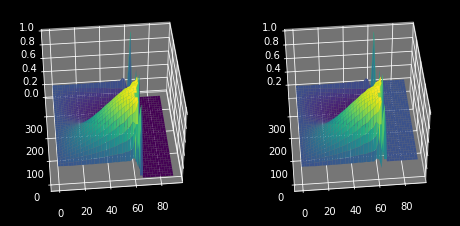

In [22]:
cinc = np.linspace(0, 1, 11)
sun_theta = np.degrees(np.arccos(cinc[-8]))
print(sun_theta)
shadow_table = r.get_shadow_table(rms_slope, sun_theta, solar_az, sl)
new_shadow_table = r.get_shadow_table(rms_slope, sun_theta, solar_az, new_sl)

# cartesian_sun = r.sph2cart(*np.radians((sun_theta, 270)))

# theta_surf_sun = np.arccos(np.dot(cartesian_surf, cartesian_sun))
# new_shadow_table = shadow_table.copy()
# new_shadow_table[new_shadow_table <= 0] = np.mean(new_shadow_table[:, 0])
# new_shadow_table[theta_surf_sun < -np.pi/2] = 1

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(45, -95)
ax.plot_surface(theta_surf, azimuth_surf, shadow_table, cmap='viridis')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(45, -95)
ax.plot_surface(theta_surf, azimuth_surf, new_shadow_table, cmap='viridis')

In [109]:
np.arccos(np.dot(cartesian_surf, cartesian_sun))

array([[1.36943841, 1.36956275, 1.36993562, ..., 1.55684458, 1.56381637,
        1.57079633],
       [1.36943841, 1.37561913, 1.38203287, ..., 1.72720732, 1.73458388,
        1.74176783],
       [1.36943841, 1.38148457, 1.3937359 , ..., 1.89688716, 1.90490355,
        1.91251823],
       ...,
       [1.36943841, 1.35761187, 1.34601941, ..., 1.21509816, 1.22187355,
        1.22907442],
       [1.36943841, 1.36349888, 1.35780849, ..., 1.38607092, 1.39284256,
        1.39982482],
       [1.36943841, 1.36956275, 1.36993562, ..., 1.55684458, 1.56381637,
        1.57079633]])

In [33]:
# Example csv for Ben et al. (THEMIS)
# shadow_table[:, 33:] = 1
# np.savetxt('shadow_example.csv', shadow_table, delimiter=',')

"""Import instructions:
import numpy as np
d = np.loadtxt('shadow_example.csv', delimiter=',')
facet_theta = np.linspace(0, 90, d.shape[1])
facet_az = np.linspace(0, 360, d.shape[0])
"""

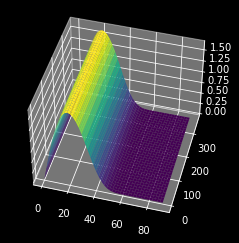

In [9]:
# Get probability of certain facets, given rms slope dist
slope_correction = r.slope_dist(np.radians(theta_surf), np.radians(rms_slope))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, -75)
ax.plot_surface(theta_surf, azimuth_surf, slope_correction, cmap='viridis')

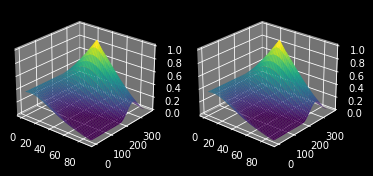

In [24]:
# Project facet vectors onto plane perp to spacecraft vec
# 1 - result seems to produce reasonable distribution of visible slopes

cartesian_sc = r.sph2cart(*np.radians((40, 280)))

# Steps (see view_correction)
proj = r.proj_orthogonal(cartesian_surf, cartesian_sc)
visible = 1-np.linalg.norm(proj, axis=2)
cos_angle = np.dot(cartesian_surf, cartesian_sc)
visible[cos_angle < 0] = 0

# Comparison
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(25, -50)
ax.plot_surface(theta_surf, azimuth_surf, visible, cmap='viridis')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(25, -50)
vis_corr = r.view_correction(cartesian_surf, cartesian_sc)
ax.plot_surface(theta_surf, azimuth_surf, vis_corr, cmap='viridis')


Text(0.5, 0, 'P(shadowed)')

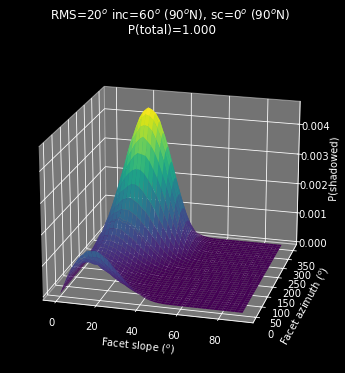

In [11]:
# Full corrected shadow table
sc_theta = 0
shadow_prob = r.get_shadow_prob(rms_slope, sun_theta, sun_az, sc_theta, sc_az, sl)

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.view_init(20, -75)
# ax.plot_surface(theta_surf, azimuth_surf, slopes, cmap='viridis')
ax.plot_surface(theta_surf, azimuth_surf, shadow_prob, cmap='viridis')
ax.set_title(f'RMS={rms_slope}$^o$ inc={sun_theta}$^o$ ({sun_az}$^o$N), sc={sc_theta}$^o$ ({sc_az}$^o$N)\n P(total)={np.sum(shadow_prob):.3f}')
ax.set_xlabel('Facet slope ($^o$)')
ax.set_ylabel('Facet azimuth ($^o$)')
ax.set_zlabel('P(shadowed)')